# Scene Dimensionality Analysis

Using the Standard Background Dataset

# Load the libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2

In [2]:
# Constants
DATASET = "./dataset"
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [3]:
# Load class labels
class_dict = pd.read_csv(os.path.join(DATASET, "labels_class_dict.csv"))
class_names = class_dict['class_names'].tolist()

In [4]:
# Load dataset metadata
metadata = pd.read_csv(os.path.join(DATASET, "metadata.csv"))

In [5]:
# Define Data Augmentation Pipeline using Albumentations
def get_train_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),  # Random rotation up to ±30 degrees
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    ])

train_augmentations = get_train_augmentations()

/var/folders/jk/nydd6s6n72nb5jfk957jjyd80000gn/T/ipykernel_22184/2012421417.py:7: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
/var/folders/jk/nydd6s6n72nb5jfk957jjyd80000gn/T/ipykernel_22184/2012421417.py:8: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),


In [6]:
def load_data(metadata_df, dataset_path, augment=False):
    images, masks = [], []
    
    for _, row in metadata_df.iterrows():
        img_path = os.path.join(dataset_path, row["image_path"])
        mask_path = os.path.join(dataset_path, row["label_colored_path"])  

        if not os.path.exists(mask_path):
            print(f"Warning: Mask not found for {row['image_path']}, skipping...")
            continue
        
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Failed to load image {row['image_path']}, skipping...")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Failed to load mask {row['label_colored_path']}, skipping...")
            continue
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

        # Apply augmentation if enabled
        if augment:
            augmented = train_augmentations(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]

        img = img / 255.0  # Normalize image to [0, 1]
        mask = mask.astype(np.uint8)  # Ensure mask is integer

        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

In [7]:
# Load training and validation datasets
X_train, y_train = load_data(metadata, DATASET, augment=True)
X_val, y_val = load_data(metadata, DATASET, augment=False)  # No augmentation for validation set

In [8]:
# Normalize class labels to start from 0
unique_labels = np.unique(y_train)
label_mapping = {old_label: idx for idx, old_label in enumerate(unique_labels)}
y_train = np.vectorize(label_mapping.get)(y_train).astype(np.int32)
y_val = np.vectorize(label_mapping.get)(y_val).astype(np.int32)

# Ensure the correct shape (batch_size, height, width, 1)
y_train = y_train.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
y_val = y_val.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

NUM_CLASSES = len(unique_labels)  # Use correct number of classes

In [9]:
# Debug: Print dataset information
print(f"Dataset loaded: {len(X_train)} training images, {len(X_val)} validation images")
print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Remapped unique values in y_train: {np.unique(y_train)}")

Dataset loaded: 715 training images, 715 validation images
Shape of X_train: (715, 256, 256, 3), Shape of y_train: (715, 256, 256, 1)
Remapped unique values in y_train: [0 1 2 3 4 5 6 7 8 9]


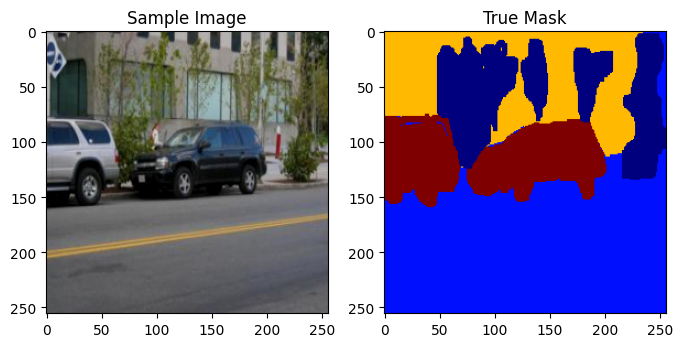

In [10]:
# Debug: Show a random image and its mask before training
index = np.random.randint(0, len(X_train))
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train[index])
plt.title("Sample Image")
plt.subplot(1, 2, 2)
plt.imshow(y_train[index].squeeze(), cmap="jet")
plt.title("True Mask")
plt.show()

In [11]:
def unet_model(input_shape=(256, 256, 3), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder with Skip Connections
    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.Concatenate()([u1, c3])  # Skip connection
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.Concatenate()([u2, c2])  # Skip connection
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.Concatenate()([u3, c1])  # Skip connection
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # Output Layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)  # For multi-class segmentation

    model = keras.Model(inputs, outputs)
    return model

In [12]:
# Compile Model
model = unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 554s 12s/step - accuracy: 0.1790 - loss: 2.2548 - val_accuracy: 0.3462 - val_loss: 1.7577
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 550s 12s/step - accuracy: 0.3115 - loss: 1.7861 - val_accuracy: 0.4118 - val_loss: 1.5483
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 552s 12s/step - accuracy: 0.3980 - loss: 1.6103 - val_accuracy: 0.4488 - val_loss: 1.4903
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 550s 12s/step - accuracy: 0.4017 - loss: 1.5816 - val_accuracy: 0.4542 - val_loss: 1.4477
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 545s 12s/step - accuracy: 0.4405 - loss: 1.5007 - val_accuracy: 0.4637 - val_loss: 1.4229
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 544s 12s/step - accuracy: 0.4633 - loss: 1.4402 - val_accuracy: 0.5170 - val_loss: 1.3021
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 547s 12s/step - accuracy: 0.4947 - loss: 1.3748 - val_accuracy: 0.5333 - val_loss: 1.2794
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 560s 12s/step - accuracy: 0.5232 - loss: 1.3069 - val_accuracy: 0.

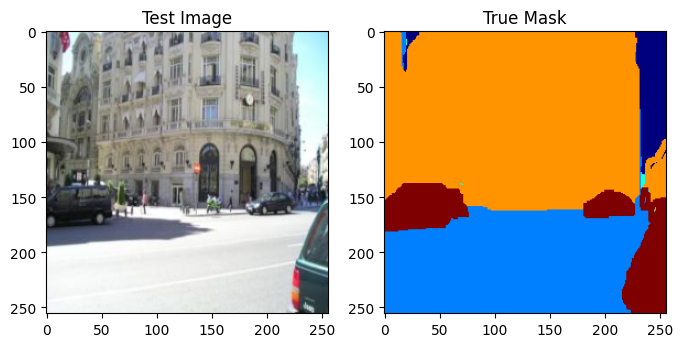

In [40]:
# Predict and show the result
index = np.random.randint(0, len(X_val))
test_img = X_val[index]
true_mask = y_val[index]

# Show the test & true mask
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("Test Image")
plt.subplot(1, 2, 2)
plt.imshow(true_mask.squeeze(), cmap="jet")
plt.title("True Mask")
plt.show()

In [41]:
# Ensure correct input shape for prediction
predicted_mask = model.predict(test_img[np.newaxis, ...])[0]
predicted_mask = np.argmax(predicted_mask, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


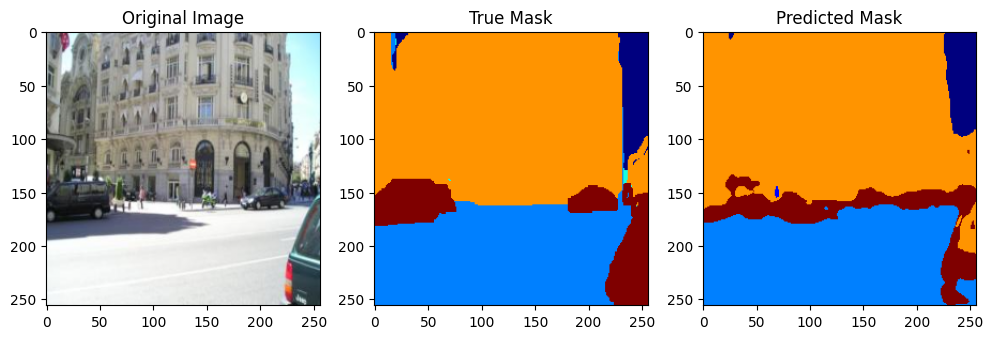

In [42]:
# Display results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_img)
ax[0].set_title("Original Image")
ax[1].imshow(true_mask.squeeze(), cmap="jet")
ax[1].set_title("True Mask")
ax[2].imshow(predicted_mask, cmap="jet")
ax[2].set_title("Predicted Mask")
plt.show()

In [16]:
# Load the dataset
meta_data = pd.read_csv(DATASET + "/metadata.csv")

print(meta_data.head())
# Perform 85/15 split for train / test
test = meta_data.sample(frac=0.15, random_state=42)
train = meta_data.drop(test.index)

   image_id  image_width  image_height          image_path  \
0        47          320           240  images/0000047.jpg   
1        51          320           240  images/0000051.jpg   
2        59          320           240  images/0000059.jpg   
3        72          320           240  images/0000072.jpg   
4        87          320           240  images/0000087.jpg   

           label_colored_path              label_layers_path  \
0  labels_colored/0000047.png  labels_raw/0000047.layers.txt   
1  labels_colored/0000051.png  labels_raw/0000051.layers.txt   
2  labels_colored/0000059.png  labels_raw/0000059.layers.txt   
3  labels_colored/0000072.png  labels_raw/0000072.layers.txt   
4  labels_colored/0000087.png  labels_raw/0000087.layers.txt   

               label_regions_path              label_surfaces_path  \
0  labels_raw/0000047.regions.txt  labels_raw/0000047.surfaces.txt   
1  labels_raw/0000051.regions.txt  labels_raw/0000051.surfaces.txt   
2  labels_raw/0000059.regions.tx

In [17]:
class_dict = pd.read_csv(DATASET + '/labels_class_dict.csv')
# Get class names
class_names = class_dict['class_names'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['sky', 'tree', 'road', 'grass', 'water', 'building', 'mountain', 'foreground', 'unknown']
Class RGB values:  [[68, 1, 84], [72, 40, 140], [62, 74, 137], [38, 130, 142], [31, 158, 137], [53, 183, 121], [109, 205, 89], [180, 222, 44], [49, 104, 142]]
